In [2]:
import network_diffusion as nd
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm
from utils import functions, models, networks

%load_ext autoreload
%autoreload 2

In [3]:
functions.set_seed(42)

# the path to events
dataset_name = 'manufacturing-sample'
path_events = "network_diffusion/tests/data/" + dataset_name + ".csv"
delimiter = ";"

# as per the initial CogSNet paper ("Social Networks through the Prism of Cognition")
# these parameters performed relatively well
forgetting_type = "exponential"
snapshot_interval = 24
edge_lifetime = 7
mu = 0.8
theta = 0.1
units = 3600

In [4]:
temporal_network = nd.TemporalNetwork.from_cogsnet(
            forgetting_type,
            snapshot_interval,
            edge_lifetime,
            mu,
            theta,
            units,
            path_events,
            delimiter)
temporal_network = functions.preprocess_temporal_network(temporal_network, theta, True)

static_network = functions.create_static_network(path_events, delimiter)
static_network = nd.TemporalNetwork.from_nx_layers(55 * [static_network])

In [6]:
N_REPETITIONS = 100

seeding_budget_active = [1, 5, 15, 25, 50]
epsilon_values = [0.005, 0.01, 0.025, 0.05, 0.1]
trials_nr_values = [1]

results = []
for seeding_budget in seeding_budget_active:
    for epsilon in epsilon_values:
        for trials_nr in trials_nr_values:
            results_temporal = []
            results_static = []
            for i in tqdm(range(N_REPETITIONS)):
                tnem = nd.models.TemporalNetworkEpistemologyModel(
                    seed_selector=nd.seeding.RandomSeedSelector(),
                    seeding_budget=(100-seeding_budget, seeding_budget),
                    trials_nr=trials_nr,
                    epsilon=epsilon,
                )

                # define simulators for temporal (CogSNet) and static networks (where static has huge edge lifetime)
                experiment_temporal = nd.Simulator(model=tnem, network=temporal_network)
                experiment_static = nd.Simulator(model=tnem, network=static_network)

                # run the experiments
                result_cogsnet = experiment_temporal.perform_propagation(n_epochs=54, patience=1)
                results_temporal.append(result_cogsnet)
                result_static = experiment_static.perform_propagation(n_epochs=54, patience=1)
                results_static.append(result_static)

            epochs, start_A, start_B, final_A, final_B = functions.get_metrics(results_temporal)
            results.append([dataset_name, 'Temporal', epsilon, trials_nr, seeding_budget, epochs, start_A, start_B, final_A, final_B])

            epochs, start_A, start_B, final_A, final_B = functions.get_metrics(results_static)
            results.append([dataset_name, 'Static', epsilon, trials_nr, seeding_budget, epochs, start_A, start_B, final_A, final_B])

            with open('tnem_cogsnet/results/' + dataset_name + '-CogSNet-' + str(epsilon) + '-' + str(trials_nr) + '-' + str(seeding_budget) + '.pickle', 'wb') as results_temporal_file:
                pickle.dump(results_temporal, results_temporal_file)

            with open('tnem_cogsnet/results/' + dataset_name + '-Static-' + str(epsilon) + '-' + str(trials_nr) + '-' + str(seeding_budget) + '.pickle', 'wb') as results_static_file:
                pickle.dump(results_static, results_static_file)
                
results_df = pd.DataFrame(results, columns=['dataset', 'method', 'epsilon', 'trials_nr', 'budget', 'epochs', 'start_A', 'start_B', 'final_A', 'final_B'])
results_df.to_csv('tnem_cogsnet/results/experiment_results.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


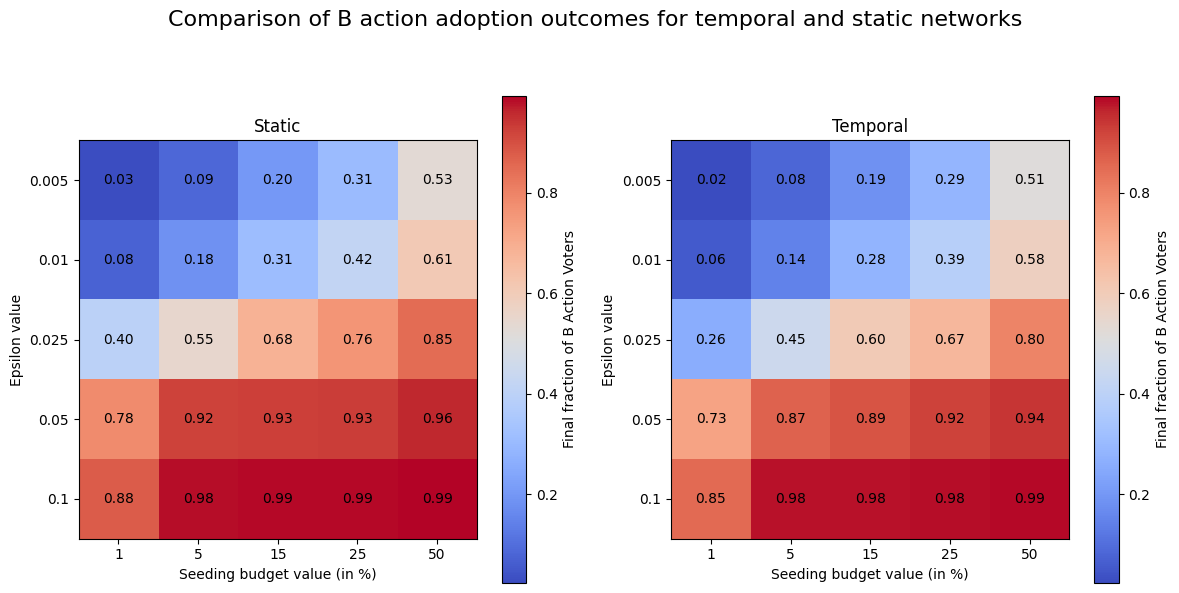

In [7]:
functions.visualize_results_as_heatmap(
    results_df,
    index='epsilon',
    columns='budget',
    values='final_B',
    title='Comparison of B action adoption outcomes for temporal and static networks',
    colorbar_label='Final fraction of B Action Voters',
    x_label='Seeding budget value (in %)',
    y_label='Epsilon value'
)